<a href="https://colab.research.google.com/github/EyalKoubi/CloudProject/blob/main/CloudGameBeforeDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive

[Errno 2] No such file or directory: '/content/drive/MyDrive'
/content


In [1]:
!pip install firebase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


statistics


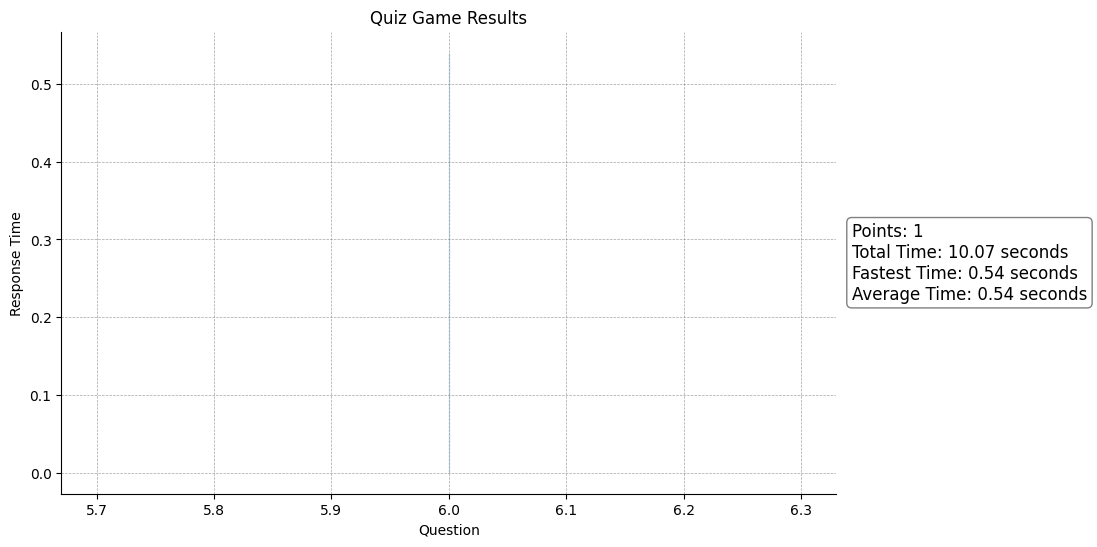

In [48]:
################ inports #########################################################################
import ipywidgets as widgets
from IPython.display import display
import random
from firebase import firebase
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Button
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from IPython.display import clear_output

# Initialize the Firebase connection
FBconn = firebase.FirebaseApplication('https://new-proj-917e8-default-rtdb.firebaseio.com/', None)

############################### get function #######################################################

# Function to retrieve all questions from Firebase
def get_all_questions():
    result = FBconn.get('/Questions', None)
    questions = []
    if result:
        for key, value in result.items():
            question = {
                'question': value['question'],
                'options': value['options'],
                'correctOption': value['correctOption']
            }
            questions.append(question)
    return questions

####################################### statistic screen ######################################################

def statisticScreen(right_answers, response_times, total_time):
    # Calculate the average response time for right answers
    right_response_times = [t for t in response_times if t >= 0]
    avg_response_time = np.mean(right_response_times)

    # Generate the data for the area plot
    categories = list(range(1, len(response_times) + 1))
    response_times = [t if t >= 0 else np.nan for t in response_times]

    # Create the figure and axes for the graph
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.fill_between(categories, response_times, color='lightblue', alpha=0.8)

    # Set axes labels and title
    ax.set_xlabel('Question')
    ax.set_ylabel('Response Time')
    ax.set_title('Quiz Game Results')

    # Customize the graph appearance
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Create the text annotations for details
    points_text = f'Points: {right_answers}'
    total_time_text = f'Total Time: {total_time} seconds'
    fastest_time_text = f'Fastest Time: {min(right_response_times)} seconds'
    avg_time_text = f'Average Time: {avg_response_time:.2f} seconds'

    details_text = f'{points_text}\n{total_time_text}\n{fastest_time_text}\n{avg_time_text}'

    ax.text(1.02, 0.5, details_text, transform=ax.transAxes, ha='left', va='center', fontsize=12,
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))
    
    main_container = widgets.VBox()

    container = widgets.VBox()

    # Create a container for the graph
    graph_container = widgets.Output()
    # with graph_container:
    #     display(fig)

    # Create a container for the details
    details_container = widgets.Output()

    # Add the graph and details containers to the main container
    container.children = [graph_container, details_container]

    # Create the Back and Try Again buttons
    btn_back = widgets.Button(description='Back')
    btn_try_again = widgets.Button(description='Try Again')

    # Function to handle button clicks
    def handle_button_click(b):
        if b.description == 'Back':
            clear_output(wait=True)
            display(createPlayerScreen())
        elif b.description == 'Try Again':
            clear_output(wait=True)
            quizScreen()

    # Assign the button click handlers
    btn_back.on_click(handle_button_click)
    btn_try_again.on_click(handle_button_click)

    # Create a container for the buttons
    buttons_container = widgets.HBox([btn_back, btn_try_again])

    main_container.children = [container,buttons_container]

    # Return the main_container
    return main_container

####################################### quiz screen ######################################################

def quizScreen():
    # Create a submit button
    submit_button = widgets.Button(description='Submit')

    # Create a question widget
    question_widget = widgets.HTML()

    # Create a radio button widget
    options_widget = widgets.RadioButtons()

    # Create a box to hold the question and options
    question_container = widgets.VBox([question_widget, options_widget])

    # Create a list to store burndown icons
    burndown_icons = []

    # Create a burndown graph widget
    burndown_graph = widgets.HTML()

    # Get all questions
    questions = get_all_questions()

    # Shuffle the questions randomly
    random.shuffle(questions)

    # Set the initial question index to 0
    current_question_index = 0

    # Create an array to store the time taken for each question
    time_array = [-1] * len(questions)

    # Create a variable to store the total time taken
    total_time = 0

    # Function to update the question and options
    def update_question():
        nonlocal current_question_index
        nonlocal total_time

        # Check if all questions have been answered
        if current_question_index >= len(questions):
          num_correct = 0  # Variable to store the number of correct answers

          for i in range(len(burndown_icons)):
              total_time += time_array[i]
              if burndown_icons[i] == 'X':
                  time_array[i] = -1
              else:
                  num_correct += 1
          total_time = round(total_time, 2)        
          screen_container.close()
          display(statisticScreen( num_correct, time_array, total_time))        
          return

        # Get the current question and options
        question = questions[current_question_index]['question']
        options = questions[current_question_index]['options']

        # Update the question widget and options widget
        question_widget.value = f"{question}"
        options_widget.options = options

        # Reset the options widget selection
        options_widget.value = None

        # Function to calculate and update the time taken for the current question
        def update_time(change):
            nonlocal current_question_index

            if current_question_index < len(questions) and options_widget.value is not None:
                current_time = time.time() - start_time
                time_array[current_question_index] = round(current_time, 2)

        # Register the update_time function to be called when the options are changed
        options_widget.observe(update_time, 'value')

        # Start the timer for the current question
        start_time = time.time()

    # Function to handle button click event
    def submit_button_clicked(button):
        nonlocal current_question_index

        # Check if an option has been selected
        if options_widget.value is None:
            return

        # Check if the selected option is correct
        selected_option = options_widget.value
        correct_option = questions[current_question_index]['correctOption']
        is_correct = selected_option == correct_option

        # Add 'V' or 'X' to burndown_icons based on correctness
        burndown_icons.append('V' if is_correct else 'X')

        # Increment the current_question_index
        current_question_index += 1

        # Update the burndown graph
        update_burndown_graph()

        # Update the question and options
        update_question()

    # Function to update the burndown graph
    def update_burndown_graph():
        graph_html = ''
        for icon in burndown_icons:
            graph_html += f'{icon}' if icon == 'V' else f'{icon}'
        graph_html += ''
        burndown_graph.value = graph_html

    # Update the question and options initially
    update_question()

    # Create a box to hold the burndown graph and submit button
    bottom_container = widgets.HBox([submit_button])

    # Create a box to hold the entire screen
    screen_container = widgets.VBox([burndown_graph, question_container, bottom_container])

    # Display the screen container
    display(screen_container)

    # Register the button click event handler
    submit_button.on_click(submit_button_clicked)

####################################### welcome screen ####################################################

def createWelcomeScreen():
    # Create main title widget
    title_widget = widgets.HTML("<h1>Welcome to the Python Game</h1>")
    title_widget.add_class("main-title")

    # Create second title widget
    subtitle_widget = widgets.HTML("<h2>It's like Squid Game but here you stay alive :)</h2>")
    subtitle_widget.add_class("subtitle")

    def handle_manager_button_click(b):
        screen_container.close()
        display(createPopup())

    def handle_player_button_click(b):
        screen_container.close()
        display(createPlayerScreen())

    # Create manager button widget
    manager_button = widgets.Button(description="Manager")
    manager_button.add_class("button-manager")
    manager_button.on_click(handle_manager_button_click)

    # Create player button widget
    player_button = widgets.Button(description="Player")
    player_button.add_class("button-player")
    player_button.on_click(handle_player_button_click)

    # Create button container widget
    button_container = widgets.VBox([manager_button, player_button])
    button_container.add_class("button-container")

    # Create screen container widget
    screen_container = widgets.VBox([title_widget, subtitle_widget, button_container])
    screen_container.add_class("screen-container")

    return screen_container

####################################### popup screen ###############################################################

def createPopup():
    overlay = widgets.Output(layout={'border': '1px solid black', 'background-color': 'rgba(0, 0, 0, 0.5)', 'padding': '20px'})
    overlay.add_class("popup-overlay")

    def handle_exit_button_click(b):
        overlay.close()
        display(createWelcomeScreen())

    def handle_submit_button_click(b):
        choice = password_input.value
        if choice != "shablool":
            error_label.value = "The choice is incorrect, please try again"
        else:
            overlay.close()
            display(createManagerScreen())

    with overlay:
        exit_button = widgets.Button(description="X", button_style="danger")
        exit_button.add_class("exit-button")
        exit_button.on_click(handle_exit_button_click)

        password_input = widgets.Password(placeholder="Enter password")
        password_input.add_class("password-input")

        error_label = widgets.HTML(value="", layout={'color': 'red'})
        error_label.add_class("error-label")

        submit_button = widgets.Button(description="Submit")
        submit_button.add_class("submit-button")
        submit_button.on_click(handle_submit_button_click)

        content = widgets.VBox([widgets.HBox([exit_button], layout={'justify_content': 'flex-end'}),
                               password_input, error_label, submit_button])
        content.add_class("popup-content")

        display(content)

    return overlay

overlay = None

####################################### exit button ######################################################################

def handle_exit_button_click(b):
  overlay.close()
  display(createManagerScreen())

####################################### add quiz button ##################################################################

def handle_add_quiz_button_click(b):
    overlay.clear_output()  # Clear the output instead of closing it
    createAddQuiz(handle_exit_button_click)  # Pass the exit callback

####################################### remove quiz button ##################################################################

def handle_remove_quiz_button_click(b):
    overlay.clear_output()  # Clear the output instead of closing it
    createRemoveQuiz()  # Display the remove quiz screen

####################################### add quiz screen #######################################################################

def createAddQuiz(exit_callback):
    global overlay  # Declare overlay as a global variable

    def handle_exit_button_click_to_manager(b):
      form.close()
      overlay.close()
      display(createManagerScreen())

    form = widgets.VBox()

    exit_div = widgets.VBox(layout={'display': 'flex', 'justify_content': 'flex-end'})
    exit_button = widgets.Button(description="X")
    exit_button.button_style = "danger"
    exit_button.on_click(handle_exit_button_click_to_manager)
    exit_div.children = [exit_button]
    form.children = [exit_div]

    question_input = widgets.Text(placeholder="Question")
    option1_input = widgets.Text(placeholder="Option 1")
    option2_input = widgets.Text(placeholder="Option 2")
    option3_input = widgets.Text(placeholder="Option 3")
    option4_input = widgets.Text(placeholder="Option 4")
    correct_input = widgets.Dropdown(options=["Option 1", "Option 2", "Option 3", "Option 4"])
    submit_button = widgets.Button(description="Submit")
    error_label = widgets.HTML(value="One of the fields is empty.", layout={'display': 'none', 'color': 'red'})
    success_label = widgets.HTML(value="The quiz added successfully!", layout={'display': 'none', 'color': 'green'})
    form.children += (question_input, option1_input, option2_input, option3_input, option4_input, correct_input,
                      submit_button, error_label, success_label)

    def handle_submit_button_click(b):
        question = question_input.value
        option1 = option1_input.value
        option2 = option2_input.value
        option3 = option3_input.value
        option4 = option4_input.value
        options = [option1, option2, option3, option4]
        correct = int(correct_input.value.split(" ")[1])

        if not question or not option1 or not option2 or not option3 or not option4 or not correct:
            error_label.layout.display = 'block'
            success_label.layout.display = 'none'
        else:
            # Check if the question already exists
            existing_questions = FBconn.get('/Questions', None)  # Assuming 'questions' is the path to the question data in your Firebase database

            if existing_questions:
                existing_questions = existing_questions.values()
                if any(q['question'] == question for q in existing_questions):
                    error_label.value = "The question already exists."
                    error_label.layout.display = 'block'
                    success_label.layout.display = 'none'
                    return

            # Add the quiz to the database
            data = {
                'question': question,
                'options': options,
                'correctOption': options[correct-1]
            }
            result = FBconn.post('/Questions', data)  # Assuming 'questions' is the path to the question data in your Firebase database

            if result:
                error_label.layout.display = 'none'
                success_label.layout.display = 'block'
                question_input.value = ""
                option1_input.value = ""
                option2_input.value = ""
                option3_input.value = ""
                option4_input.value = ""
            else:
                error_label.value = "Failed to add the quiz to the database. Please try again."



    submit_button.on_click(handle_submit_button_click)

    overlay.close()
    display(form)

####################################### remove quiz screen #######################################################################

def createRemoveQuiz():
    def removeQuestion(questionId):
        FBconn.delete(f'/Questions/{questionId}', None)
        question_element = next(
            (c for c in remove_quiz_container.children if c.question_id == questionId), None
        )
        if question_element:
            remove_quiz_container.children = tuple(
                c for c in remove_quiz_container.children if c != question_element
            )

    def handle_exit_button_click_to_manager(b):
        remove_quiz_container.close()
        exit_button.close()
        overlay.close()
        display(createManagerScreen())

    remove_quiz_container = widgets.VBox()
    question_containers = []

    questions = FBconn.get('/Questions', None)
    if questions:
        for question_id, question_data in questions.items():
            question_container = widgets.HBox()
            question_text = widgets.HTML(f"<p>{question_data['question']}</p>")
            remove_button = widgets.Button(description="X", button_style="danger")
            remove_button.on_click(lambda b, q_id=question_id: removeQuestion(q_id))
            question_container.children = [question_text, remove_button]
            question_container.question_id = question_id
            question_containers.append(question_container)

    exit_button = widgets.Button(description="Exit", button_style="danger")
    exit_button.on_click(handle_exit_button_click_to_manager)
    remove_quiz_container.children = question_containers + [exit_button]

    overlay.close()
    display(remove_quiz_container)

####################################### manager screen #######################################################################

def createManagerScreen():
    global overlay  # Declare overlay as a global variable

    # Create the overlay widget
    overlay = widgets.Output(layout={'border': '1px solid black', 'background-color': 'rgba(0, 0, 0, 0.5)', 'padding': '20px'})



    with overlay:
        def handle_exit_button_click_to_popup(b):
          overlay.close()
          display(createPopup())

        # Create the manager screen widget
        manager_screen = widgets.VBox()

        # Create the exit button
        exit_button = widgets.Button(description="X")
        exit_button.button_style = "danger"
        exit_button.on_click(handle_exit_button_click_to_popup)

        # Create the manager title
        manager_title = widgets.HTML("<h1>Manager Screen</h1>")

        # Create the add quiz button
        add_quiz_button = widgets.Button(description="Add Quiz")
        add_quiz_button.on_click(handle_add_quiz_button_click)
        add_quiz_button.style.button_color = "lightblue"

        # Create the remove quiz button
        remove_quiz_button = widgets.Button(description="Remove Quiz")
        remove_quiz_button.on_click(handle_remove_quiz_button_click)
        remove_quiz_button.style.button_color = "lightblue"

        # Arrange the widgets
        manager_screen.children = [exit_button, manager_title, add_quiz_button, remove_quiz_button]
        manager_screen.layout = {'border': '1px solid black', 'padding': '10px', 'margin': '10px'}

        # Display the manager screen widget
        display(manager_screen)

    return overlay

####################################### player screen #######################################################################

def createPlayerScreen():

    # Create the player screen widget
    player_screen = widgets.VBox()

    def handle_start_play_button_click(b):
      player_screen.close()
      quizScreen()

    def handle_statistics_button_click(b):
      print("statistics")

    # Create the exit button
    exit_button = widgets.Button(description="Exit")
    exit_button.button_style = "danger"

    # Create the player title
    player_title = widgets.HTML("<h1>Player Screen</h1>")

    # Create the "Start Play" button
    start_play_button = widgets.Button(description="Start Play")
    start_play_button.style.button_color = "lightblue"
    start_play_button.on_click(handle_start_play_button_click)

    # Create the "Statistics" button
    statistics_button = widgets.Button(description="Statistics")
    statistics_button.style.button_color = "lightblue"
    statistics_button.on_click(handle_statistics_button_click)

    # Arrange the widgets
    player_screen.children = [exit_button, player_title, start_play_button, statistics_button]
    player_screen.layout = {'border': '1px solid black', 'padding': '10px', 'margin': '10px'}

    def exit_player_handler(b):
      player_screen.close()
      display(createWelcomeScreen())

    exit_button.on_click(exit_player_handler)

    return player_screen

####################################### activate screens #######################################################################

screen_container = createWelcomeScreen()
display(screen_container)
